# CP 3 Aprendizaje de Máquinas
---
## Árboles de Decisión y Random Forest

### Ejercicio 1: Iris 

To demonstrate the use of a decision tree classifier we use the Iris data set.

Load the Iris data set

In [5]:
from sklearn import datasets

iris = datasets.load_iris()

The Iris data set has four features (sepal length, sepal width, petal length, petal width) which can be used to classify Iris flowers into three species denoted as "0", "1", "2" (setosa, versicolor, virginica)

In [6]:
import pandas as pd

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target
df['species_names'] = df.species
df.replace({'species_names':{
            0:iris['target_names'][0],
            1:iris['target_names'][1],
            2:iris['target_names'][2]            
        }}, inplace=True)
df.columns = [item.replace(' (cm)', '') for item in df.columns]
df.head()

,sepal length,sepal width,petal length,petal width,species,species_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [7]:
#Data points count value for each class labels..

df.species.value_counts()

0    50
1    50
2    50
Name: species, dtype: int64

The scatter plot shows the three species of Iris in different colors plotted with the petal length and petal width on the y axis

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Iris species')

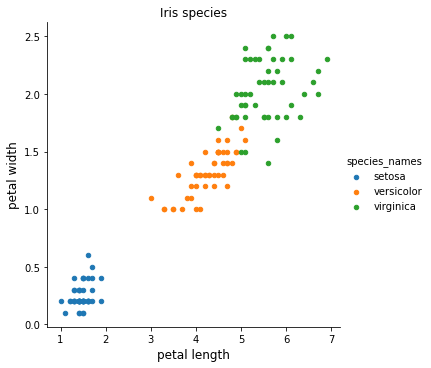

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'axes.labelsize': 'large'})
plt.rcParams.update({'axes.titlesize': 'large'})
g = sns.FacetGrid(df, hue='species_names', size=5)
g.map(plt.scatter, 'petal length', 'petal width', s=20)
g.add_legend()
g.fig.gca().set_title('Iris species')

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=.3)

### Ejercicio 3: Iris con Random Forest

In [10]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
tree_clf.score(X_test,y_test)

0.9333333333333333

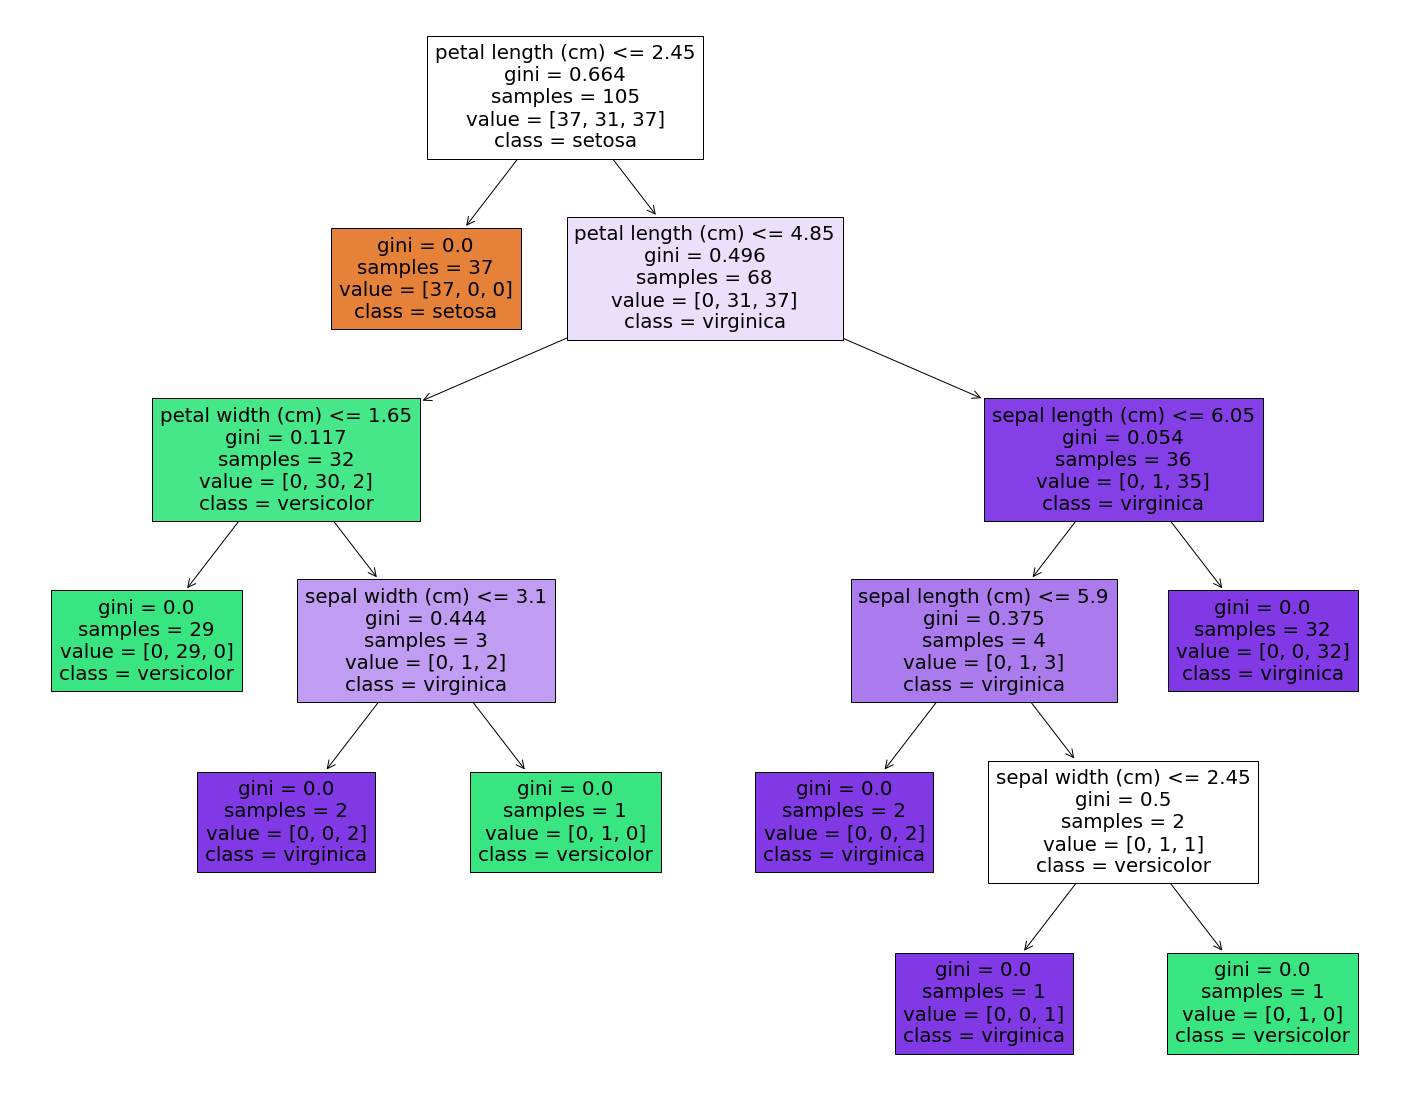

In [11]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))
_ = plot_tree(tree_clf, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

### Ejercicio 3: Iris con Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
forest_clf.score(X_test,y_test)

0.9333333333333333

### Ejercicio 4: Visualizando la Importancia de las Características

Una gran ventaja de los clasificadores basados en árboles es que nos permite hacernos una idea de la importancia relativa de cada carcterística en función de como se dividen los nodos en la fase de entrenamiento. Para ello, tanto el `DecisionTreeClassifier` como el `RandomForestClassifier` de `scikit-learn` proporciona un atributo llamado `feature_importances_`. Esto devuelve un arrray de valores que suman 1. Cuanto mayor sea la puntuación, más importante será la característica. La puntuación se calcula como la reducción total (normalizada) del criterio aportado por esa característica.

In [14]:
def plot_feature_importance(feature_imp: np.ndarray):
    "Grafica la importancia de cada característica"
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features", pad=15, size=14)

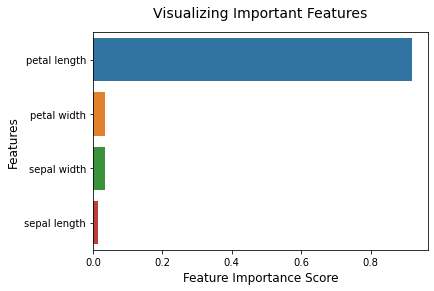

In [18]:
feature_imp = pd.Series(tree_clf.feature_importances_, 
                        index=['sepal length', 'sepal width', 'petal length', 'petal width']).sort_values(ascending=False)
plot_feature_importance(feature_imp)

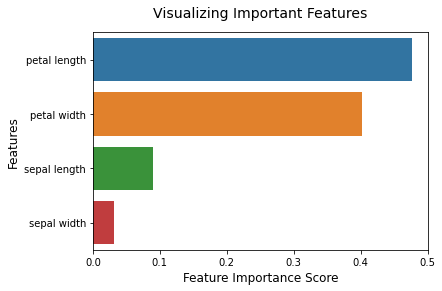

In [16]:
feature_imp = pd.Series(forest_clf.feature_importances_, 
                        index=['sepal length', 'sepal width', 'petal length', 'petal width']).sort_values(ascending=False)
plot_feature_importance(feature_imp)

### Ejercicio 4: Espacios de Decision

In [10]:
import numpy as np
%matplotlib inline
from matplotlib.colors import ListedColormap

In [11]:
plt.rcParams.update({'figure.titlesize': 'large'})
step = 0.04

def mesh_plot(x, y, species, ax, clf):
    values = species.unique()
    colors = sns.color_palette()[:len(values)]
    xx, yy = np.meshgrid(
        np.arange(x.min() - 0.1, x.max() + 0.1, step),
        np.arange(y.min() - 0.1, y.max() + 0.1, step))
    mesh_predict = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    mesh_predict = mesh_predict.reshape(xx.shape)
    for i in range(len(colors)):
        ax.scatter(x[df.species == values[i]], y[df.species == values[i]], color=colors[i])
        ax.set_xlim(x.min() - 0.2, x.max() + 0.2)
        ax.set_ylim(y.min() - 0.2, y.max() + 0.2)
    ax.pcolormesh(xx, yy, mesh_predict,
        cmap=ListedColormap(sns.color_palette()[:3]), alpha=0.2, shading='auto')

In [12]:
def plot_features(df, feat1, feat2, clsf, ax, depth=None):
    X = df[[feat1, feat2]]
    y = df.species
    fit_clsf = clsf(max_depth=depth).fit(X, y)
    ax.set(xlabel=feat1, ylabel=feat2)
    mesh_plot(df[feat1], df[feat2], df.species, ax, fit_clsf) 
    

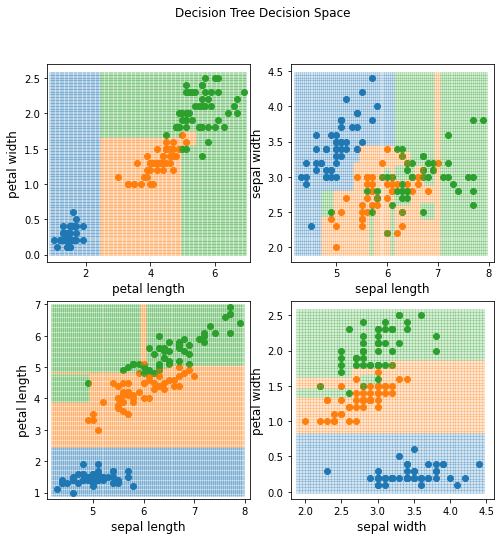

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
# fig.tight_layout()
fig.suptitle('Decision Tree Decision Space')

plot_features(df, 'petal length', 'petal width', DecisionTreeClassifier, ax1)
plot_features(df, 'sepal length', 'sepal width', DecisionTreeClassifier, ax2)
plot_features(df, 'sepal length', 'petal length', DecisionTreeClassifier, ax3)
plot_features(df, 'sepal width', 'petal width', DecisionTreeClassifier, ax4)

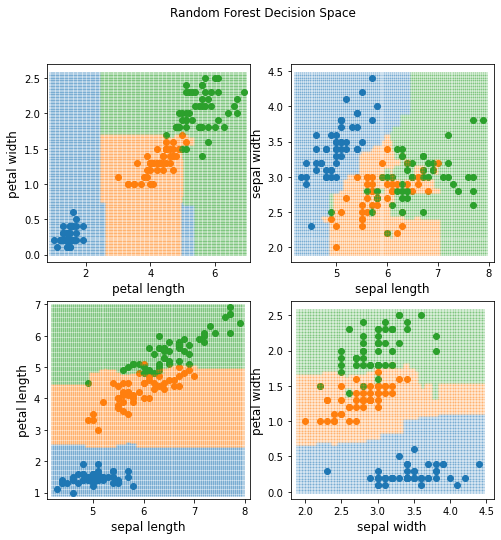

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
# fig.tight_layout()
fig.suptitle('Random Forest Decision Space')

plot_features(df, 'petal length', 'petal width', RandomForestClassifier, ax1)
plot_features(df, 'sepal length', 'sepal width', RandomForestClassifier, ax2)
plot_features(df, 'sepal length', 'petal length', RandomForestClassifier, ax3)
plot_features(df, 'sepal width', 'petal width', RandomForestClassifier, ax4)

### Ejercicio 6: Profundidad de los árboles

In [46]:
def plot_dt_by_depth(df, feat1, feat2, ax):
    X = df[[feat1, feat2]]
    for idx in range(0, 3):
      clf = DecisionTreeClassifier(max_depth=idx + 1, random_state=0).fit(X, df.species)
      mesh_plot(df[feat1], df[feat2], df.species, ax[idx], clf)

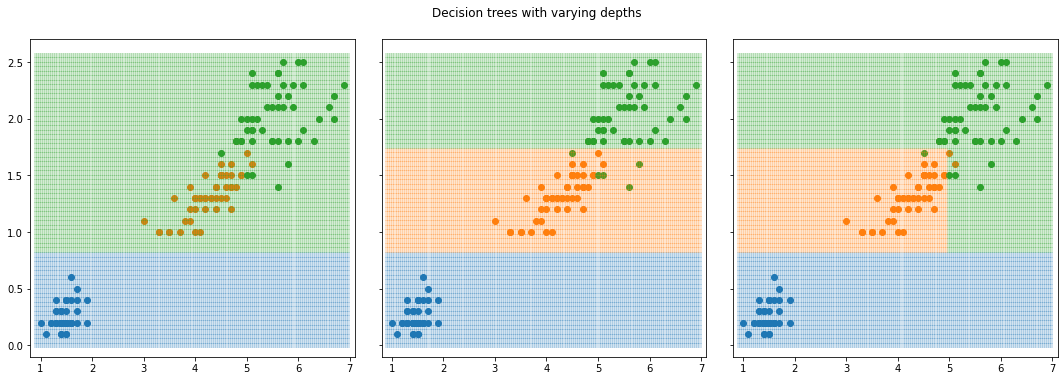

In [48]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 5), squeeze=True)
fig.tight_layout()
fig.suptitle('Decision trees with varying depths', y=1.05)

plot_dt_by_depth(df, 'petal length', 'petal width', ax)

### Ejercicio 5: DT y RF con Rotten Tomatoes

In [15]:
import os
from pathlib import Path
from typing import List
from sklearn.feature_extraction.text import CountVectorizer 

In [31]:
path_p = Path("txt_sentoken/pos")
path_n = Path("txt_sentoken/neg")

ds_p = list(path_p.iterdir())     # directorio donde están las críticas positivas
ds_n = list(path_n.iterdir())     # directorio donde están las críticas negativas

def convert_file_to_text(file_path: Path) -> str:
    with open(file_path) as f:
        return ''.join(f.readlines())
    
texts_p = [convert_file_to_text(file) for file in ds_p]    # Lista de críticas positivas
texts_n = [convert_file_to_text(file) for file in ds_n]    # Lista de críticas negativas

In [18]:
vectorizer = CountVectorizer()
mt = vectorizer.fit_transform(texts_p + texts_n)
mta = mt.toarray()

y = [1]*1000 + [0]*1000

X_train_rt, X_test_rt, y_train_rt, y_test_rt = train_test_split(mta, y, train_size=0.60)

In [19]:
rt_dt = DecisionTreeClassifier()
rt_dt.fit(X_train_rt, y_train_rt)
rt_dt.score(X_test_rt,y_test_rt)

0.6475

In [20]:
rt_rf = RandomForestClassifier()
rt_rf.fit(X_train_rt, y_train_rt)
rt_rf.score(X_test_rt,y_test_rt)

0.79125